In [1]:
!pip install ninja
!git clone https://github.com/NVlabs/stylegan3.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'stylegan3' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append('./stylegan3')

import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
from PIL import Image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

import torch_utils
import legacy
import dnnlib

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load in the trained Stylegan3 model
network_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema']
        G = G.eval().requires_grad_(False).to(device)
c = None

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def get_latents(amount, seed, shape = 512):
    latents = torch.from_numpy(np.random.RandomState(seed).randn(amount, shape)).cuda()
    w = torch.empty(amount, 16, shape)
    for i in range(latents.shape[0]):
        w[i] = G.mapping(latents[i][None], c)
    return latents, w

def face_from_latent(net, latents, img_size, show_face = False, use_w=False, outdir = None):
    outputs = torch.empty((len(latents), 3, img_size, img_size))
    transform=transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    for i, latent in enumerate(latents):
        if use_w:
            face = net.synthesis(latent[None], noise_mode = "none")
        else:
            face = net(latent[None], c)
        face = np.clip(np.rint((face.cpu() + 1.0) / 2.0 * 255.0), 0.0, 255.0).numpy().astype(np.uint8)
        face = face.transpose((0, 2, 3, 1))
        img = Image.fromarray(face[0], 'RGB')
        img = img.resize((img_size,img_size), resample = PIL.Image.LANCZOS)
        if show_face:
            plt.axis('off')
            plt.title("Face "+str(i))
            plt.imshow(img)
            plt.show()
        if not outdir is None:
          img.save(outdir + "Image %d.png" % i)
        img = transform(img)
        outputs[i] = img
    return outputs

def train(netD, netG, num_iters, batch_size, img_size, seed, criterion, optimizer):
    losses = []
    for i in range(num_iters):
        z, w = get_latents(batch_size, np.random.seed(seed))
        z = z.to(torch.float32).to(device)
        w = w.to(device) # naar float32?
        x = face_from_latent(netG, w, img_size, use_w = True).to(device)

        netD.zero_grad()

        output = netD(x).squeeze()

        errD = criterion(output, w[:,0])
        errD.backward()
        optimizer.step()
        
        if i % 5 == 0:
          print('[%d/%d]\tLoss_D: %.4f' % (i+1, num_iters, errD.item()))

        losses.append(errD.item())

    return losses

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels = 3, feature_maps = 64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 512, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Set number of gpu's and device
img_size = 64

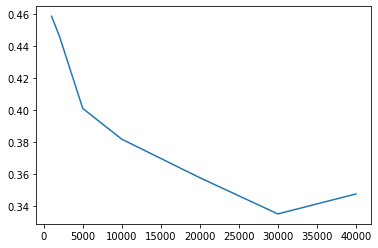

In [47]:
iters = [1000, 2000, 5000, 10000, 20000, 30000, 40000]
plt.plot(iters, losses)

In [48]:
print(losses)

[0.45849865674972534, 0.44617408514022827, 0.4008164405822754, 0.3816019892692566, 0.3575010299682617, 0.3348602056503296, 0.347345232963562]


In [26]:
netD_stylegan1024_5000 = Discriminator().to(device)
optimizerD_Adam_W = optim.Adam(netD_stylegan1024_5000.parameters(), lr=0.0002)

path = '/content/drive/MyDrive/Internship/internship-transfer-files/intermediate_results/netD_stylegan3-1024_w_5000.pt'
checkpoint = torch.load(path)
netD_stylegan1024_5000.load_state_dict(checkpoint['model_state_dict'])
optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
iter = checkpoint['iter']
loss = checkpoint['loss']

netD_stylegan1024_5000.eval()
print(iter)
print(loss)

5000
0.4008164405822754


In [22]:
seed = 42
outdir = '/content/drive/MyDrive/Internship/results/stylegan1024/'
os.makedirs(outdir, exist_ok=True)
batch_sz = 10

z, w = get_latents(batch_sz, seed)
z = z.to(torch.float32).to(device)
w = w.to(device)
faces = face_from_latent(G, w, img_size, use_w=True).to(device)
# highq_faces = face_from_latent(G, w, 1024, use_w=True, outdir = outdir + "Original_").to(device)

In [23]:
netD_stylegan1024_5000.zero_grad()
new_w = netD_stylegan1024_5000(faces).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[:,None,:].repeat(1,16,1)

torch.Size([10, 512])


In [24]:
loss = nn.MSELoss()(new_w_reshaped, w)
loss

tensor(0.5027, device='cuda:0', grad_fn=<MseLossBackward0>)

In [25]:
new_faces = face_from_latent(G, new_w_reshaped.detach(), img_size=1024, use_w=True, outdir = outdir + "Recon_5000_").to(device)

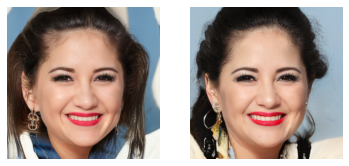

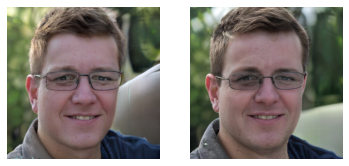

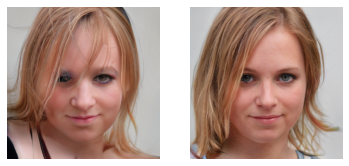

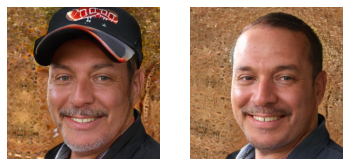

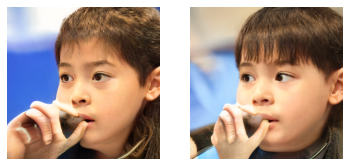

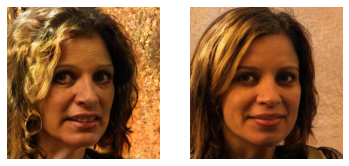

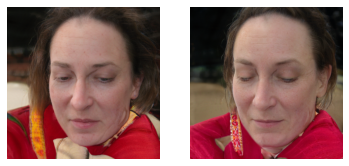

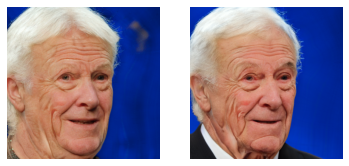

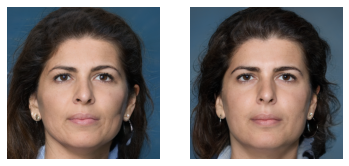

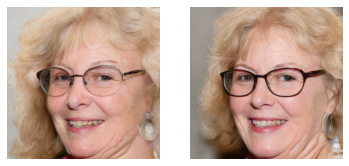

In [ ]:
for i in range(10):
    _, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Original_Image %d.png" % i)
    axs[0].imshow(img)
    axs[0].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_40000_Image %d.png" % i)
    axs[1].imshow(img)
    axs[1].axis('off')
    plt.show()

In [ ]:
img_me = mpimg.imread("/content/drive/MyDrive/Internship/reconstructions/Original_me.jpg")
img = Image.fromarray(img_me, 'RGB')
plt.axis('off')
plt.imshow(img)

img = img.resize((img_size,img_size), resample = PIL.Image.LANCZOS)

transform=transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
img = transform(img)
img = img[None, :, :, :]
print(img.shape)

In [ ]:
netD_stylegan1024_40000.zero_grad()
new_w = netD_stylegan1024_40000(img.to(device)).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[None,:].repeat(1,16,1)

torch.Size([512])


In [ ]:
new_faces = face_from_latent(G, new_w_reshaped.detach(), img_size=1024, show_face=True, use_w=True, outdir = "/content/drive/MyDrive/Internship/reconstructions/Recon_me_4").to(device)

(-0.5, 1023.5, 1023.5, -0.5)

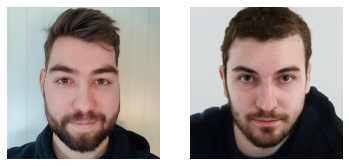

In [ ]:
_, axs = plt.subplots(1, 2)
axs = axs.flatten()
img = mpimg.imread("/content/drive/MyDrive/Internship/reconstructions/Original_me.jpg")
axs[0].imshow(img)
axs[0].axis('off')
img = mpimg.imread("/content/drive/MyDrive/Internship/reconstructions/Recon_me_4.png")
axs[1].imshow(img)
axs[1].axis('off')

In [ ]:
netD_stylegan1024_10000 = Discriminator().to(device)
optimizerD_Adam_W = optim.Adam(netD_stylegan1024_10000.parameters(), lr=0.0002)

path = '/content/drive/MyDrive/Internship/internship-transfer-files/intermediate_results/netD_stylegan3-1024_w_10000.pt'
checkpoint = torch.load(path)
netD_stylegan1024_10000.load_state_dict(checkpoint['model_state_dict'])
optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
iter = checkpoint['iter']
loss = checkpoint['loss']

netD_stylegan1024_10000.eval()
print(iter)

10000


In [ ]:
netD_stylegan1024_10000.zero_grad()
new_w = netD_stylegan1024_10000(faces).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[:,None,:].repeat(1,16,1)

torch.Size([10, 512])


In [ ]:
loss = nn.MSELoss()(new_w_reshaped, w)
loss

tensor(0.4135, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
new_faces = face_from_latent(G, new_w_reshaped.detach(), img_size=1024, use_w=True, outdir = outdir + "Recon_10000_").to(device)

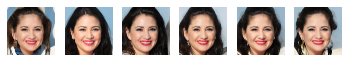

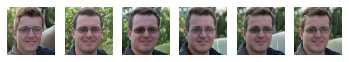

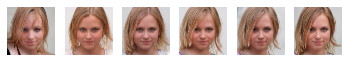

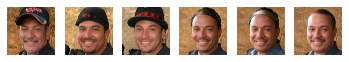

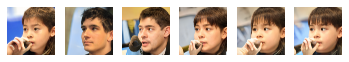

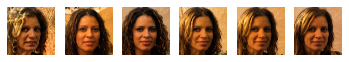

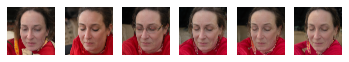

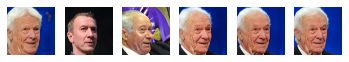

In [ ]:
for i in range(10):
    _, axs = plt.subplots(1, 6)
    axs = axs.flatten()
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Original_Image %d.png" % i)
    axs[0].imshow(img)
    axs[0].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_5000_Image %d.png" % i)
    axs[1].imshow(img)
    axs[1].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_10000_Image %d.png" % i)
    axs[2].imshow(img)
    axs[2].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_20000_Image %d.png" % i)
    axs[3].imshow(img)
    axs[3].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_30000_Image %d.png" % i)
    axs[4].imshow(img)
    axs[4].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/stylegan1024/Recon_40000_Image %d.png" % i)
    axs[5].imshow(img)
    axs[5].axis('off')
    plt.show()

In [ ]:
netD_stylegan1024_40000 = Discriminator().to(device)
optimizerD_Adam_W = optim.Adam(netD_stylegan1024_40000.parameters(), lr=0.0002)

path = '/content/drive/MyDrive/Internship/internship-transfer-files/intermediate_results/netD_stylegan3-1024_w_40000.pt'
checkpoint = torch.load(path)
netD_stylegan1024_40000.load_state_dict(checkpoint['model_state_dict'])
optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
iter = checkpoint['iter']
loss = checkpoint['loss']

netD_stylegan1024_40000.eval()
print(iter)

40000


In [ ]:
netD_stylegan1024_40000.zero_grad()
new_w = netD_stylegan1024_40000(faces).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[:,None,:].repeat(1,16,1)

torch.Size([10, 512])


In [ ]:
loss = nn.MSELoss()(new_w_reshaped, w)
loss

tensor(0.3062, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
new_faces = face_from_latent(G, new_w_reshaped.detach(), img_size=1024, use_w=True, outdir = outdir + "Recon_40000_").to(device)